# Plot Model Data Fits
This notebook demonstrates how models can be loaded from our pre-saved weights and used to predict output mode weights.
The accuracy of predications is visualized by plotting them against data recorded in this paper: [https://doi.org/10.1103/PhysRevX.11.021060]

All models are saved as full pytorch so they can be loaded from files without importing any custom classes using:
```python
torch.load(<path-to-model>, weights_only=False)
```

In [1]:
# General imports
import torch, os
import numpy as np
from matplotlib import pyplot as plt

from oil.complex import ComplexConverter # Used to convert split-value complex representations (used for ml) into true torch.complex values.
from oil.datasets import HDF5Dataset # Used to load compressed training data.

## Load the models
Model class definitions will automatically be loaded as well.

In [2]:
# Load the model weights 
model_names = ['base-mlp', 'siren', 'f-net'] # List of models to be loaded 
models = {}
for _name in model_names:
    models[_name] = torch.load(os.path.join("Data","Weights","plotWeights",_name), weights_only=False)


In [3]:
# Display f-net details 
models['f-net']

FourierFeatureMLP(
  (features): FourierFeatures(in_features=1, out_features=11, frequencies=5)
  (mlp): MLP(
    (0): Linear(in_features=11, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=40, bias=True)
  )
)

## Load the Dataset
Note the the data loaded here was recorded by Matthès, Bromberg, de Rosny, and Popoff for this paper: [https://doi.org/10.1103/PhysRevX.11.021060]

In [4]:
data = HDF5Dataset.load(os.path.join('Data','Data','Compression_20-mode','mode_0_data.h5'))

# Get data information 
STEPS = len(data)
MODES = len(data[0][-1])

# Data is stored as a tuple: (input deformation, output mode weights)
data[0]

(tensor(0., dtype=torch.float64),
 tensor([-9.2991e-01-0.2443j, -4.9995e-02-0.1890j,  1.4900e-02-0.0021j,
          6.2781e-02+0.0302j,  2.5738e-02+0.0100j,  7.1385e-03-0.0088j,
         -9.7089e-03+0.0065j,  2.9781e-04+0.0061j,  1.2356e-02+0.0114j,
          1.0612e-03+0.0046j,  8.9622e-02+0.1115j, -8.1512e-02+0.0331j,
          8.0153e-03-0.0007j,  5.0022e-03-0.0143j,  2.2740e-03+0.0017j,
         -9.2668e-03-0.0016j,  2.7434e-03-0.0009j, -4.0917e-03-0.0028j,
          4.4398e-02+0.0134j, -1.0195e-02-0.0007j], dtype=torch.complex128))

## Plot Model Fits

### Get data to plot

In [5]:
# Get data from pre-existing dataset (ground truth)
data_x = np.zeros(STEPS, dtype=float)
data_y = np.zeros((STEPS, MODES), dtype=complex)
for _i in range(STEPS):
    x, target = data[_i]
    data_x[_i] = x.detach().numpy()
    data_y[_i,:] = target.detach().numpy()

In [6]:
# Get data from model predications (interpolation)
n_pts = 1000
re_im_cc = ComplexConverter(expand_method='concat',representation='real-imag') # Formats network outputs
fine_x = torch.linspace(0,1,n_pts).unsqueeze(1)
fine_y = {}
for _name, _model in models.items():
    fine_y[_name] = re_im_cc.to_complex(_model(fine_x)).detach().numpy()

### Plot the data

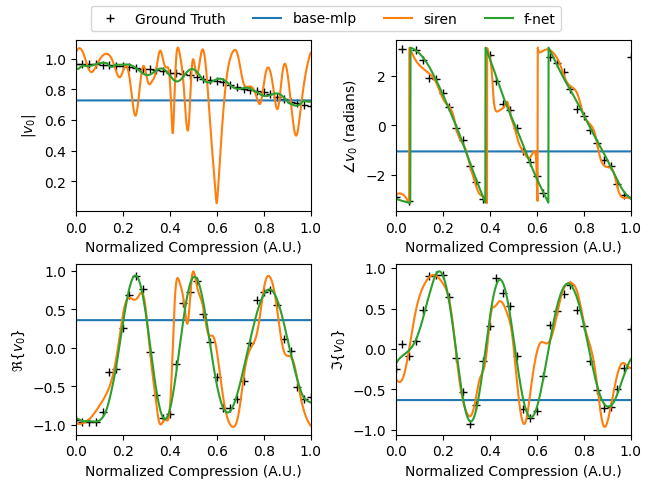

In [ ]:
plot_mode = 0
fig, axs = plt.subplots(2,2,layout='constrained')

# Assign axes
abs_ax = axs[0,0]
phase_ax = axs[0,1]
re_ax = axs[1,0]
im_ax = axs[1,1]

# Label axes
for _ax in axs.flat:
    _ax.set_xlabel("Normalized Compression (A.U.)")
    _ax.set_xlim([0,1])
abs_ax.set_ylabel(fr"$|v_{{{plot_mode}}}|$")
phase_ax.set_ylabel(fr"$\angle v_{{{plot_mode}}}$ (radians)")
re_ax.set_ylabel(fr"$\Re\{{v_{{{plot_mode}}}\}}$")
im_ax.set_ylabel(fr"$\Im\{{v_{{{plot_mode}}}\}}$")

# Plot absolute values
abs_ax.plot(data_x, np.abs(data_y[:,plot_mode]), linestyle='', marker='+', color='black', label='Ground Truth')
for _name, _y_data in fine_y.items():
    abs_ax.plot(fine_x, np.abs(_y_data[:,plot_mode]), label=_name)

# Plot phases
phase_ax.plot(data_x, np.angle(data_y[:,plot_mode]), linestyle='', marker='+', color='black', label='Ground Truth')
for _name, _y_data in fine_y.items():
    phase_ax.plot(fine_x, np.angle(_y_data[:,plot_mode]), label=_name)


# Plot real
re_ax.plot(data_x, np.real(data_y[:,plot_mode]), linestyle='', marker='+', color='black', label='Ground Truth')
for _name, _y_data in fine_y.items():
    re_ax.plot(fine_x, np.real(_y_data[:,plot_mode]), label=_name)

# Plot imaginary
im_ax.plot(data_x, np.imag(data_y[:,plot_mode]), linestyle='', marker='+', color='black', label='Ground Truth')
for _name, _y_data in fine_y.items():
    im_ax.plot(fine_x, np.imag(_y_data[:,plot_mode]), label=_name)


handles, labels = abs_ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper center', ncols=len(model_names)+1)

plt.show()